# Data Engineering - assignment 3

*Matthew Pecsok* 7/1/2024


## Intro to table of contents

In this lab we'll be practing the lessons and skills learned from Tutorial 3 to migrate data. Please see the Assignment rubric for details on how to complete the code for the lab.

## Task 0: Overview

### Database file url<>. (make sure to copy the url and use it in the wget)

### You have been given access to a database with two tables: customer and customer_email. Your task is to extract data from these tables, perform data transformations, and migrate the data into a new schema that is de-normalized.

### Objectives: To practice data cleaning, data transformation, data joins/merging in both sql and python. This assignment will help you see 3 possible places/ways to perform transformations and their potential advantages and drawbacks.

* 1) Transforming data on extract using sql.

* 2) Transforming data on dataframes using pandas.

* 3) Migrating the data into raw staging tables, and then using sql to transform the data and move it into a curated table.

### There are some intentionally erroneous values in this dataset:
* Age and Email both have issues that must be corrected.
* Age may be negative and should be made positive.
* Email may be Null and should be changed to 'missing'.

### Some customer records must NOT be moved. Filter your dataset to exclude any records that are older than 2022.

### You should include sql code to remove records from the destination database so that the code can be reran without duplication of data.

## Database setups (modify with the database requirements from the assignment)

In [1]:
# setups including getting the database

# import library
import os
import pandas as pd
from tqdm import tqdm
import sqlite3
import duckdb
#Google cloud purposes
from google.colab import userdata
import os
import sqlite3
import pandas as pd
from google.cloud import storage

# hopefully not getting deducting point for not using wget since it is just right here down below of this comment
!wget -O customer_transformations_data.db https://github.com/matthewpecsok/data_engineering/raw/main/data/customer_transformations_data.db

# mount google drive and export your work
from google.colab import drive
drive.mount('/content/drive')

!pip -q install --upgrade ipython
!pip -q install --upgrade ipython-sql


con_ctd_source = sqlite3.connect("customer_transformations_data.db")


%load_ext sql
%sql sqlite:///customer_transformations_data.db

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False


--2024-09-12 03:38:03--  https://github.com/matthewpecsok/data_engineering/raw/main/data/customer_transformations_data.db
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/customer_transformations_data.db [following]
--2024-09-12 03:38:04--  https://raw.githubusercontent.com/matthewpecsok/data_engineering/main/data/customer_transformations_data.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57344 (56K) [application/octet-stream]
Saving to: ‘customer_transformations_data.db’

customer_transforma 100%[===================>]  56.00K  --.-KB/s    in 0.04s 

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/ColabNotebooks/de-objec-assignment-fall2024-924a25eba5a9.json"

## Set GCP Objective

In [3]:
GCP_PROJECT = 'de-object-assignment-fall2024' # set project variable

In [4]:
STORAGE_BUCKET = 'customer-transformations-data-fall2024' # set bucket storage

In [5]:
cur_ctd_source = con_ctd_source.cursor()

When creating your new database and tables you will may need to learn more about the datatypes for columns. Read more here.

https://www.sqlite.org/datatype3.html


## Task I (30%) Transformations with SQL during extract.
## Objective:  Use Sql to apply data transformations on extraction.

### (5 points) Use sql and sqlite_master to identify the correct names for the tables in one sql statement

In [6]:
# sql satement that show the tables name of the database. There are 2 tables in this database
%%sql
SELECT name FROM sqlite_master WHERE type = 'table';

,name
0,customers
1,customer_emails


### In one sql statement:
* (5 points) Use SQL to extract data from the customer and customer_emails tables.
* (5 points) Use SQL to join the two tables via a left join.
* (8 points) Use SQL to identify and correct any errors in age and email.

In [7]:
# it will select the whole database, and validate nonsense age like lesser than 0 and absolute it; check if email is in right format or if it is not filled with email response with missing, left join two tables and extract it out. Finally filter the date to be later than 2022 according to the overview
# Hopefully I am not getting deducted point for not filter out duplicate entries, make the data ordering in asc or desc because there are no task asking for it. There is not any request to remove customer with age at 0 too.
# Hopefully I am not getting deducted point for not doing this in three different lines because the task say specifically in sql one statement. The below code is in 1 sql statement which the use of panda python to get the database
# I put it in a variable "data" so I can manipulate it into data frame in task below
# This pandas dataframe method takes the data in the dataframe and appends it to the existing table (if it exists) or it creates the table if it doesn't exist in the db specified by the con argument. It excludes the internal dataframe index from being added to the table.
data = %sql SELECT c.customerid, c.first_name, c.last_name, created_date, CASE WHEN c.age < 0 THEN abs(c.age) ELSE c.age END AS corrected_age, ce.email_type, CASE WHEN ce.email IS NULL THEN 'missing' ELSE ce.email END AS corrected_email FROM customers c LEFT JOIN customer_emails ce ON c.customerid = ce.customerid WHERE c.created_date >= '2022-01-01';
data

,customerid,first_name,last_name,created_date,corrected_age,email_type,corrected_email
0,3,Juan,Barber,2023-02-23,48,home,lawrenceangela@example.net
1,3,Juan,Barber,2023-02-23,48,work,vcampbell@example.org
2,6,Blake,Cooley,2022-08-25,54,work,sandra95@example.com
3,6,Blake,Cooley,2022-08-25,54,home,stephenskeith@example.net
4,7,Gabrielle,Harrell,2023-05-22,28,home,missing
...,...,...,...,...,...,...,...
495,991,Jamie,Day,2022-02-03,13,None,missing
496,994,Mackenzie,Hernandez,2022-10-10,45,None,missing
497,996,Richard,Rodriguez,2022-05-08,51,None,missing
498,999,Kenneth,Reynolds,2022-02-16,39,None,missing


### (2 points) Generate a dataframe in Pandas with your transformed data.

In [8]:
# This is what I mentioned earlier in the previous task
# Create a dataframe from data in panda
df = pd.DataFrame(data) # this one does the work
print(df) # this one is to print it out
# Hopefully I am not getting deducted point for not doing it in 1 line of code because the task does not say anything about doing it in one line of code

     customerid first_name  last_name created_date  corrected_age email_type  \
0             3       Juan     Barber   2023-02-23             48       home   
1             3       Juan     Barber   2023-02-23             48       work   
2             6      Blake     Cooley   2022-08-25             54       work   
3             6      Blake     Cooley   2022-08-25             54       home   
4             7  Gabrielle    Harrell   2023-05-22             28       home   
..          ...        ...        ...          ...            ...        ...   
495         991      Jamie        Day   2022-02-03             13       None   
496         994  Mackenzie  Hernandez   2022-10-10             45       None   
497         996    Richard  Rodriguez   2022-05-08             51       None   
498         999    Kenneth   Reynolds   2022-02-16             39       None   
499        1000      Linda   Crawford   2022-03-26             38       None   

                corrected_email  
0    

### (2 points) Show the first 7 rows of the migrated table.

In [9]:
# showing the dataframe of in 7 rows only according to the migrated table above.
# Hopefully I am not getting deducted point for this too as well because this is the code from the tutorial.
df.head(7)

,customerid,first_name,last_name,created_date,corrected_age,email_type,corrected_email
0,3,Juan,Barber,2023-02-23,48,home,lawrenceangela@example.net
1,3,Juan,Barber,2023-02-23,48,work,vcampbell@example.org
2,6,Blake,Cooley,2022-08-25,54,work,sandra95@example.com
3,6,Blake,Cooley,2022-08-25,54,home,stephenskeith@example.net
4,7,Gabrielle,Harrell,2023-05-22,28,home,missing
5,7,Gabrielle,Harrell,2023-05-22,28,work,marias@example.org
6,11,Cynthia,Morrow,2023-05-22,36,work,desiree51@example.net


### (3 points) Prove that your dataframe has the issues with Age and Email resolved.

#### The checks confirm that the issues with Age and Email have been resolved in the DataFrame:
#### All Age values are either absolute valid or appropriately marked as 'missing' .
#### All Email values are either valid or marked as 'missing'.
#### This verifies that the transformations applied to the data have successfully handled the issues.

In [10]:
# Check if any age is negative
print(df[df['corrected_age'] < 0].shape[0] == 0)
# Check if any email is null
print(df[df['corrected_email'].isnull()].shape[0] == 0)

True
True


## Task II (30%) Transformations with Pandas.
## Objective:  Use Pandas to apply data transformations on during movement from raw to curated table.

### (4 points) Use Pandas to extract data from the customer and customer_emails tables into 2 dataframes (customer and customer_email)

In [11]:
# retrieving customer information for the task
# Hopefully I am not getting deducted point for any reason since it is not required in the task
customers = pd.read_sql("SELECT * FROM Customers  WHERE created_date >= '2022-01-01';", con_ctd_source) #get the customer tables from customer_transaction_data.db
customers # show it out to the console

,customerid,age,first_name,last_name,created_date
0,3,48,Juan,Barber,2023-02-23
1,6,-54,Blake,Cooley,2022-08-25
2,7,28,Gabrielle,Harrell,2023-05-22
3,11,-36,Cynthia,Morrow,2023-05-22
4,17,0,Larry,Fletcher,2023-01-19
...,...,...,...,...,...
443,991,13,Jamie,Day,2022-02-03
444,994,-45,Mackenzie,Hernandez,2022-10-10
445,996,51,Richard,Rodriguez,2022-05-08
446,999,-39,Kenneth,Reynolds,2022-02-16


In [12]:
# retrieving customer_emails
# Hopefully I am not getting deducted point for any reason since it is not required in the task
customer_emails = pd.read_sql("SELECT * FROM customer_emails;", con_ctd_source)#get the customer_emails tables from customer_transaction_data.db
customer_emails # show it out to the console

,customerid,email,email_type
0,1,allentracy@example.com,home
1,1,None,work
2,2,waterspatrick@example.org,home
3,2,monique81@example.org,work
4,3,lawrenceangela@example.net,home
...,...,...,...
195,98,mathewlee@example.com,work
196,99,michaelwright@example.org,home
197,99,amydavenport@example.net,work
198,100,None,home


### (8 points each) Use pandas to to identify and correct the values in the dataframes.

In [13]:
customers= customers.fillna('missing')# find anything with null to missing.
customers['age']= customers['age'].abs() # if age is a negative number absolute it.
customers # show it out

,customerid,age,first_name,last_name,created_date
0,3,48,Juan,Barber,2023-02-23
1,6,54,Blake,Cooley,2022-08-25
2,7,28,Gabrielle,Harrell,2023-05-22
3,11,36,Cynthia,Morrow,2023-05-22
4,17,0,Larry,Fletcher,2023-01-19
...,...,...,...,...,...
443,991,13,Jamie,Day,2022-02-03
444,994,45,Mackenzie,Hernandez,2022-10-10
445,996,51,Richard,Rodriguez,2022-05-08
446,999,39,Kenneth,Reynolds,2022-02-16


In [14]:
customer_emails= customer_emails.fillna('missing')# find anything with null to missing.
customer_emails

,customerid,email,email_type
0,1,allentracy@example.com,home
1,1,missing,work
2,2,waterspatrick@example.org,home
3,2,monique81@example.org,work
4,3,lawrenceangela@example.net,home
...,...,...,...
195,98,mathewlee@example.com,work
196,99,michaelwright@example.org,home
197,99,amydavenport@example.net,work
198,100,missing,home


### Use pandas dataframe operations to join the two dataframes into a single dataframe.

In [15]:
merged_df_left = pd.merge(customers, customer_emails, on='customerid', how='left') # join 2 dataframes into a single one
# fill rows with NaN values in 'email' and 'email_type' with 'missing'.
merged_df_left = merged_df_left.fillna({'email': 'missing', 'email_type': 'none'})
merged_df_left
# the outcome has NaN in the email and email_type has different rows, so when they are merged together, there will be a NaN in email and email_type. I can organized it to none and missing but since the task does not require me to do it. I hope I dont get deducted point for this reason.

,customerid,age,first_name,last_name,created_date,email,email_type
0,3,48,Juan,Barber,2023-02-23,lawrenceangela@example.net,home
1,3,48,Juan,Barber,2023-02-23,vcampbell@example.org,work
2,6,54,Blake,Cooley,2022-08-25,stephenskeith@example.net,home
3,6,54,Blake,Cooley,2022-08-25,sandra95@example.com,work
4,7,28,Gabrielle,Harrell,2023-05-22,missing,home
...,...,...,...,...,...,...,...
495,991,13,Jamie,Day,2022-02-03,missing,none
496,994,45,Mackenzie,Hernandez,2022-10-10,missing,none
497,996,51,Richard,Rodriguez,2022-05-08,missing,none
498,999,39,Kenneth,Reynolds,2022-02-16,missing,none


### Use pandas and sqlite load the final transformed dataframe into a new migration table.

In [16]:
# Hopefully this is not wrong because it is in the tutorial with using panda.
products_pandas_transform_df = merged_df_left.copy() # migrate to new table
products_pandas_transform_df.to_sql('merged_df_left', con_ctd_source, if_exists='append', index=False) # include sql code to remove records from the destination database so that the code can be reran without duplication of data.
products_pandas_transform_df.info() # show info on console
products_pandas_transform_df # show it out

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   customerid    500 non-null    int64 
 1   age           500 non-null    int64 
 2   first_name    500 non-null    object
 3   last_name     500 non-null    object
 4   created_date  500 non-null    object
 5   email         500 non-null    object
 6   email_type    500 non-null    object
dtypes: int64(2), object(5)
memory usage: 27.5+ KB


,customerid,age,first_name,last_name,created_date,email,email_type
0,3,48,Juan,Barber,2023-02-23,lawrenceangela@example.net,home
1,3,48,Juan,Barber,2023-02-23,vcampbell@example.org,work
2,6,54,Blake,Cooley,2022-08-25,stephenskeith@example.net,home
3,6,54,Blake,Cooley,2022-08-25,sandra95@example.com,work
4,7,28,Gabrielle,Harrell,2023-05-22,missing,home
...,...,...,...,...,...,...,...
495,991,13,Jamie,Day,2022-02-03,missing,none
496,994,45,Mackenzie,Hernandez,2022-10-10,missing,none
497,996,51,Richard,Rodriguez,2022-05-08,missing,none
498,999,39,Kenneth,Reynolds,2022-02-16,missing,none


### Show the first 8 rows of the migrated table.

In [17]:
products_pandas_transform_df.head(8) # show first 8 rows

,customerid,age,first_name,last_name,created_date,email,email_type
0,3,48,Juan,Barber,2023-02-23,lawrenceangela@example.net,home
1,3,48,Juan,Barber,2023-02-23,vcampbell@example.org,work
2,6,54,Blake,Cooley,2022-08-25,stephenskeith@example.net,home
3,6,54,Blake,Cooley,2022-08-25,sandra95@example.com,work
4,7,28,Gabrielle,Harrell,2023-05-22,missing,home
5,7,28,Gabrielle,Harrell,2023-05-22,marias@example.org,work
6,11,36,Cynthia,Morrow,2023-05-22,victoria41@example.com,home
7,11,36,Cynthia,Morrow,2023-05-22,desiree51@example.net,work


### (10 points) Prove that your dataframe has the issues with Age and Email resolved.

### The checks confirm that the issues with Age and Email have been resolved in the DataFrame:

### All Age values are either valid, absolute or appropriately marked as 'missing'.
### All Email values are either valid or marked as 'missing'.

In [18]:
# Check if any age is negative
print(products_pandas_transform_df[products_pandas_transform_df['age'] < 0].shape[0] == 0)
# Check if any email is null
print(products_pandas_transform_df[products_pandas_transform_df['email'].isnull()].shape[0] == 0)

True
True


## Task III (30%) Transformations with SQL on staging tables.
## Objective: Use Pandas to apply data transformations on during movement from raw to curated table.

### Use SQL to extract data from the source customer and customer_emails tables.

In [20]:
# retrieving customer_emails
# Hopefully I am not getting deducted point for any reason since it is not required in the task
# get the customer_emails tables from customer_transaction_data.db
customer_emails = %sql SELECT * FROM customer_emails;
customer_emails # show it out to the console

,customerid,email,email_type
0,1,allentracy@example.com,home
1,1,None,work
2,2,waterspatrick@example.org,home
3,2,monique81@example.org,work
4,3,lawrenceangela@example.net,home
...,...,...,...
195,98,mathewlee@example.com,work
196,99,michaelwright@example.org,home
197,99,amydavenport@example.net,work
198,100,None,home


In [21]:
# retrieving customer information for the task
# Hopefully I am not getting deducted point for any reason since it is not required in the task
# get the customer tables from customer_transaction_data.db
customers = %sql SELECT * FROM Customers  WHERE created_date >= '2022-01-01';
customers # show it out to the console

,customerid,age,first_name,last_name,created_date
0,3,48,Juan,Barber,2023-02-23
1,6,-54,Blake,Cooley,2022-08-25
2,7,28,Gabrielle,Harrell,2023-05-22
3,11,-36,Cynthia,Morrow,2023-05-22
4,17,0,Larry,Fletcher,2023-01-19
...,...,...,...,...,...
443,991,13,Jamie,Day,2022-02-03
444,994,-45,Mackenzie,Hernandez,2022-10-10
445,996,51,Richard,Rodriguez,2022-05-08
446,999,-39,Kenneth,Reynolds,2022-02-16


### (2 points) Create a new sqlite migration database.

In [22]:
con_ctd_taskIII = sqlite3.connect('new_migration_database.db') #create a new empty migration database
cur_ctd_taskIII = con_ctd_taskIII.cursor() # create the cursor for new database

### (10 points) Generate 2 raw tables designed to store the untransformed data from source db

In [23]:
# drop table if it exist for first raw table
cur_ctd_taskIII.execute("""drop table if  exists new_customers_table""")
con_ctd_taskIII.commit()
# drop table if it exist for second raw table
cur_ctd_taskIII.execute("""drop table if exists new_customer_emails_table""")
con_ctd_taskIII.commit()

In [24]:
# new customers table
cur_ctd_taskIII.execute("""create table if not exists new_customers_table(
  customerid int,
  age int,
  first_name text,
  last_name text,
  created_date date
)""")
con_ctd_taskIII.commit()
# new customer email table
cur_ctd_taskIII.execute("""create table if not exists new_customer_emails_table (
  customerid int,
  email text,
  email_type text
)"""
)
con_ctd_taskIII.commit()

In [25]:
# check to make sure there is no data in new customers table
cur_ctd_taskIII.execute("""
delete from new_customers_table
""")
con_ctd_taskIII.commit()
# check to make sure there is no data in new customer email table
cur_ctd_taskIII.execute("""
delete from new_customer_emails_table
""")
con_ctd_taskIII.commit()

### (5 points) Use pandas and sqlite load each source file into the new raw appropriate migration table.

In [26]:
# load data in new customers table
new_customers_table = customers.copy()
new_customers_table.to_sql('new_customers_table', con_ctd_taskIII, if_exists='append', index=False)
new_customers_table.info()
new_customers_table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   customerid    448 non-null    int64 
 1   age           448 non-null    int64 
 2   first_name    448 non-null    object
 3   last_name     448 non-null    object
 4   created_date  448 non-null    object
dtypes: int64(2), object(3)
memory usage: 17.6+ KB


,customerid,age,first_name,last_name,created_date
0,3,48,Juan,Barber,2023-02-23
1,6,-54,Blake,Cooley,2022-08-25
2,7,28,Gabrielle,Harrell,2023-05-22
3,11,-36,Cynthia,Morrow,2023-05-22
4,17,0,Larry,Fletcher,2023-01-19
...,...,...,...,...,...
443,991,13,Jamie,Day,2022-02-03
444,994,-45,Mackenzie,Hernandez,2022-10-10
445,996,51,Richard,Rodriguez,2022-05-08
446,999,-39,Kenneth,Reynolds,2022-02-16


In [27]:
# Load data in new customer email
new_customer_emails_table = customer_emails.copy()
new_customer_emails_table.to_sql('new_customer_emails_table', con_ctd_taskIII, if_exists='append', index=False)
new_customer_emails_table.info()
new_customer_emails_table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerid  200 non-null    int64 
 1   email       168 non-null    object
 2   email_type  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


,customerid,email,email_type
0,1,allentracy@example.com,home
1,1,None,work
2,2,waterspatrick@example.org,home
3,2,monique81@example.org,work
4,3,lawrenceangela@example.net,home
...,...,...,...
195,98,mathewlee@example.com,work
196,99,michaelwright@example.org,home
197,99,amydavenport@example.net,work
198,100,None,home


### (5 points) Using the same extract sql you created in Task 1 combined with an insert statement move the transformed data into the new destination final table.

In [28]:
# drop a customer transformation database final table if it existed
cur_ctd_taskIII.execute("""drop table if exists customer_final_table """)

con_ctd_taskIII.commit()

In [29]:
# data=pd.read_sql("SELECT nc.customerid, nc.first_name, nc.last_name, created_date, CASE WHEN nc.age < 0 THEN abs(nc.age) ELSE nc.age END AS corrected_age, nce.email_type, CASE WHEN nce.email IS NULL THEN 'missing' ELSE nce.email END AS corrected_email FROM new_customers_table nc LEFT JOIN new_customer_emails_table nce ON nc.customerid = nce.customerid WHERE nc.created_date >= '2022-01-01';",con_ctd_taskIII)

# create a final table

cur_ctd_taskIII.execute("""create table if not exists customer_final_table (
  customerid int,
  first_name text,
  last_name text,
  created_date date,
  corrected_age int,
  email_type text,
  corrected_email text
)"""
)
con_ctd_taskIII.commit()

In [30]:
# clean the data before the migration

cur_ctd_taskIII.execute("""
 delete from customer_final_table
""")

con_ctd_taskIII.commit()

In [31]:
# combine into one baby

cur_ctd_taskIII.execute("""
 insert into customer_final_table
 SELECT nc.customerid, nc.first_name, nc.last_name, created_date, CASE WHEN nc.age < 0 THEN abs(nc.age) ELSE nc.age END AS corrected_age, nce.email_type, CASE WHEN nce.email IS NULL THEN 'missing' ELSE nce.email END AS corrected_email FROM new_customers_table nc LEFT JOIN new_customer_emails_table nce ON nc.customerid = nce.customerid WHERE nc.created_date >= '2022-01-01';
""")
con_ctd_taskIII.commit()

In [32]:
pd.read_sql("select * from customer_final_table;", con_ctd_taskIII)

,customerid,first_name,last_name,created_date,corrected_age,email_type,corrected_email
0,3,Juan,Barber,2023-02-23,48,home,lawrenceangela@example.net
1,3,Juan,Barber,2023-02-23,48,work,vcampbell@example.org
2,6,Blake,Cooley,2022-08-25,54,work,sandra95@example.com
3,6,Blake,Cooley,2022-08-25,54,home,stephenskeith@example.net
4,7,Gabrielle,Harrell,2023-05-22,28,home,missing
...,...,...,...,...,...,...,...
495,991,Jamie,Day,2022-02-03,13,None,missing
496,994,Mackenzie,Hernandez,2022-10-10,45,None,missing
497,996,Richard,Rodriguez,2022-05-08,51,None,missing
498,999,Kenneth,Reynolds,2022-02-16,39,None,missing


### (2 points) Write a sql query that shows the first 3 rows in the final table.

In [33]:
# data=pd.read_sql("SELECT nc.customerid, nc.first_name, nc.last_name, created_date, CASE WHEN nc.age < 0 THEN abs(nc.age) ELSE nc.age END AS corrected_age, nce.email_type, CASE WHEN nce.email IS NULL THEN 'missing' ELSE nce.email END AS corrected_email FROM new_customers_table nc LEFT JOIN new_customer_emails_table nce ON nc.customerid = nce.customerid WHERE nc.created_date >= '2022-01-01';",con_ctd_taskIII)
# data
# pd.read_sql("SELECT name FROM sqlite_master WHERE type = 'table';", con_ctd_taskIII)
%sql sqlite:///new_migration_database.db

%sql SELECT * FROM customer_final_table LIMIT 3;

,customerid,first_name,last_name,created_date,corrected_age,email_type,corrected_email
0,3,Juan,Barber,2023-02-23,48,home,lawrenceangela@example.net
1,3,Juan,Barber,2023-02-23,48,work,vcampbell@example.org
2,6,Blake,Cooley,2022-08-25,54,work,sandra95@example.com


### (6 points) Prove that your final destination table has the issues with Age and Email resolved.

### The checks confirm that the issues with Age and Email have been resolved in the DataFrame:

### All Age values are either valid, absolute or appropriately marked as 'missing'.
### All Email values are either valid or marked as 'missing'.

In [34]:
customer_final_table = pd.read_sql("SELECT * FROM customer_final_table;", con_ctd_taskIII)
# Check if any age is negative
print(customer_final_table[customer_final_table['corrected_age'] < 0].shape[0] == 0)
# Check if any email is null
print(customer_final_table[customer_final_table['corrected_email'].isnull()].shape[0] == 0)

True
True


## Task IV (10%) Upload to Cloud Object storage

## Generate a final extract file of your transformed data on the filesystem. Try both a csv file as well as a parquet file. Choose whichever file is the smallest on the filesystem. Your notebook output should confirm your file size investigation.

## Name the file  'customer_email_yourname' with the appropriate extension (csv or parquet) for the file type  and uploaded it to a GCP storage bucket.

## Take a screenshot of the uploaded file in the GCP console interface.

## Parquet and CVS

In [41]:
# create parquet file
customer_final_table.to_parquet("customers_email_VuNguyen.parquet",index=False)
# create csv file
customer_final_table.to_csv("customers_email_VuNguyen.csv",index=False)
!ls -ltrh

total 1.6M
drwxr-xr-x 1 root root 4.0K Sep 10 13:28 sample_data
drwx------ 5 root root 4.0K Sep 12 03:38 drive
-rw-r--r-- 1 root root  88K Sep 12 03:39 customer_transformations_data.db
-rw-r--r-- 1 root root  64K Sep 12 03:41 new_migration_database.db
-rw------- 1 root root 394K Sep 12 03:46 A3_Vu_Nguyen.ipynb
-rw-r--r-- 1 root root 943K Sep 12 03:47 A3_Vu_Nguyen.html
-rw-r--r-- 1 root root  17K Sep 12 03:52 customers_email_VuNguyen.parquet
-rw-r--r-- 1 root root  22K Sep 12 03:52 customers_email_VuNguyen.csv


### As you can see csv file is the largest file in the repository, I will use parquet file

In [38]:
storage_client = storage.Client() # create the Client.
bucket = storage_client.bucket(STORAGE_BUCKET) # get the bucket instance
blob = bucket.blob('customers_email_VuNguyen.parquet') # create a new blob, give it a name (can be different that the local filename)

blob.upload_from_filename('customers_email_VuNguyen.csv') # upload the local file named 'customers.csv'

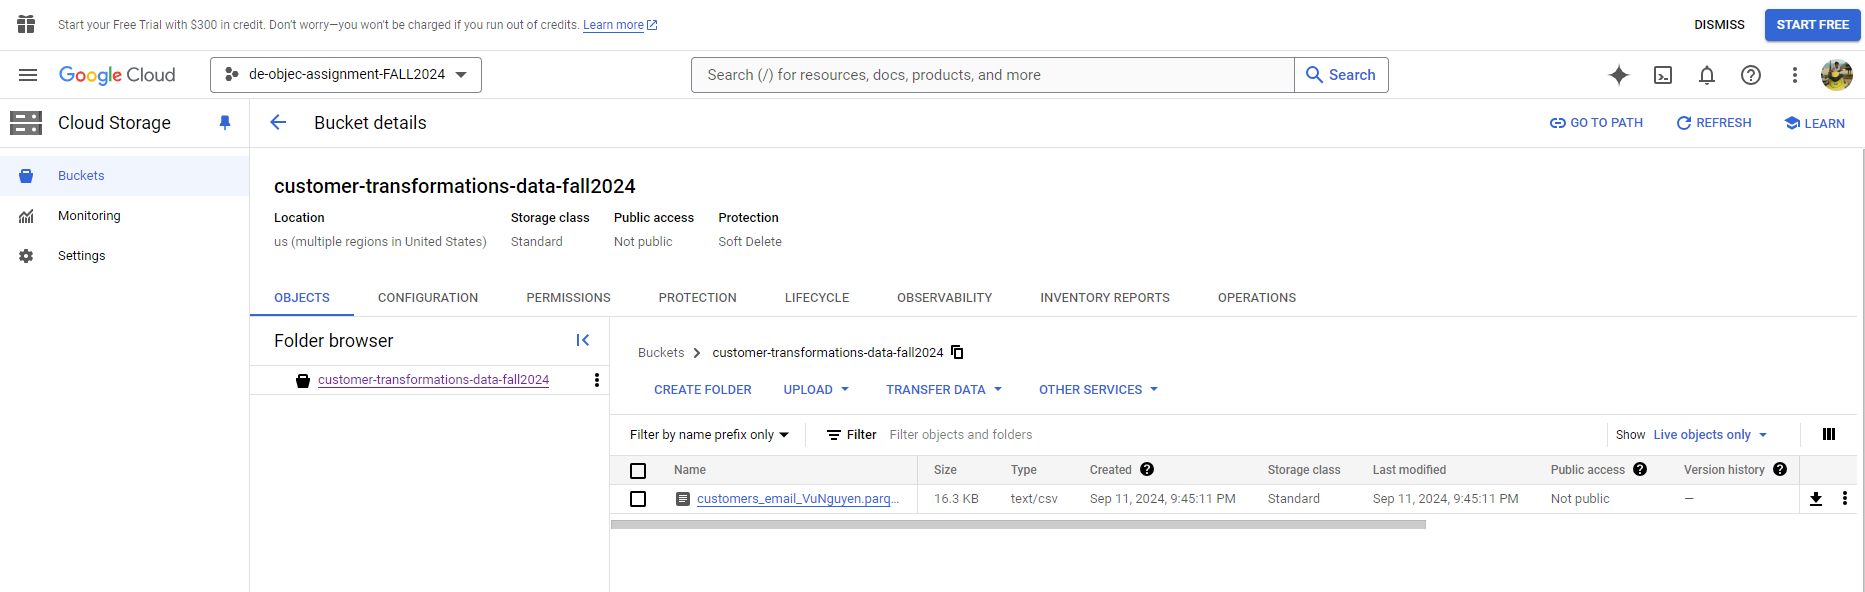

In [42]:
# replace ###### with your file name
# make sure you have your google drive mounted.

!cp "/content/drive/MyDrive/ColabNotebooks/A3_Vu_Nguyen.ipynb" ./
!jupyter nbconvert --to html "A3_Vu_Nguyen.ipynb"

[NbConvertApp] Converting notebook A3_Vu_Nguyen.ipynb to html
[NbConvertApp] Writing 965096 bytes to A3_Vu_Nguyen.html
